# Coffee
This workbook contains a simulation of a shop. It is based on events generated by tasks and is in some respects quite similar to how a GUI or computer game works, except neither of those can be run inside a Jupyter workbook!

The goal is for you to extend the simulation, from its inital state as a cake shop, to a proper coffee (and cake) shop, by adding new classes. The purpose is to learn about object oriented programming, with the added bonus of learning how a simulation may work.

A lot of code has been provided. You will need to read and understand some of it, but remember that lab time is limited. You may want to skip ahead to the questions during the lab, and come back to satisfy your curiosity as homework.

## Marking and submission

These lab exercises are marked, and contribute to your final grade. This lab exercise has 26 marks to earn, equivalent to 12% of your final grade. Most of the time where you have to add code is indicated by

`# **************************************************************** 2 marks`

with instructions above the code block. Occasionally a markdown block will request that you return to an early block and edit it. There will be no indicator in such cases.

Please submit your completed workbook to the auto marker before 2021-11-14 20:00 GMT. The workbook you submit must be an .ipynb file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (`Save and checkpoint` in the `File` menu, the icon of a floppy disk, or `Ctrl-S`). It is wise to verify it runs to completion with _Restart & Run All_ before submission.

You must comply with the universities plagiarism guidelines: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

In [1]:
%matplotlib inline
from collections import defaultdict, deque

import numpy

import matplotlib.pyplot as plt

## Helper Functions
You can, and probably should, ignore the below block. It's used by the customer arrival times simulation to arrange for a burst of customers at lunch time and at the end of the working day.

In [2]:
def consume_area(x, y, start, area):
    start = start % x[-1]
    
    segment = numpy.searchsorted(x, start)
    t = (start - x[segment]) / (x[segment+1] - x[segment])
    
    travel = 0.0
    while True:
        delta = x[segment+1] - start
        segment_area = 0.5 * ((1-t) * y[segment] + (t+1) * y[segment+1]) * delta
        if segment_area > area:
            break
        
        area -= segment_area
        travel += delta
        segment = (segment + 1) % (x.shape[0] - 1)
        
        start = x[segment]
        t = 0.0
    
    height = (1-t) * y[segment] + t * y[segment+1]
    grad = (y[segment+1] - y[segment]) / (x[segment+1] - x[segment])
    
    srt = numpy.sqrt(4*height*height + 8*grad*area)
    tra = 4 * area / (2 * height + srt)

    return travel + tra


## Task Interface
The below can be considered to be an _interface_, a specification for an object kind that we need to comply with for multiple other objects. It is not actually necesary - the below code could be deleted, none of the tasks would inherit from a base class, and everything would work just fine due to _duck typing_. However, from an understandability point of view this is strongly prefered, as it makes it clear how everything is to work. In other words, the below is a form, of documentation. It also ensures that the correct errors are thrown if a Task is not implimented completely.

In [3]:
class Task:
    def time(self):
        raise NotImplementedError

    def depends(self):
        raise NotImplementedError

    def __call__(self, timeline):
        raise NotImplementedError


## Timeline
The timeline is the most complex peice of code in the simulation, as it manages everything, in particular time. It actually has multiple independent capabilities:
 * It manages tasks, which is to it say queues them up and makes sure that they are only run when all dependencies for each task are avaliable (as in not being used by another task).
 * It handles queues (of customers), pairing off the item from the front of the queue with the object that has offered to process the queue item.
 * It manages time, specifically looping through it and starting/ending tasks at the required moments, interleaving their execution as required. It is not real time, and will jump through as fast as possible. For instance when the shop is closed and nothing is hapenning is will skip through this time period in a single step, but could take hundreds of steps in a single minute during lunchtime when there is a lot of activity.
 * Because it is a centralised object that every part of the simulation has access to it also includes an event recording system, so statistics can be recorded and visualised after a simulation has run.

You would be advised to read the interface and doc strings, but to ignore the actual code.

In [4]:
class Timeline:
    def __init__(self, **extra):
        for k, v in extra.items():
            setattr(self, k, v)
       
        self.running = []
        self.waiting = []
        
        self.queue = defaultdict(lambda: {'sink' : deque(), 'source' : deque()})
        
        self.now = 0.0
    
    
    def time(self):
        return self.now
    
    
    def __start(self):
        reservation = set()
        for _, task in self.running:
            for dep in task.depends():
                reservation.add(id(dep))
        
        # Loop queue and move over tasks
        old_waiting = self.waiting
        self.waiting = list()
        
        for task in old_waiting:
            can_run = True
            for dep in task.depends():
                if id(dep) in reservation:
                    can_run = False
                    break
            
            if can_run:
                for dep in task.depends():
                    reservation.add(id(dep))
                self.running.append([task.time(), task])
            else:
                self.waiting.append(task)

        self.running.sort()
    
    
    def simulate(self, time = 60 * 60):
        self.__start()
        self.events = defaultdict(list)
        self.now = 0.0
        
        while len(self.running)!=0:
            step = self.running[0][0] # self.running sorted so soonest to finish is first
            if step > time:
                for task in self.running:
                    task[0] -= time
                self.now = 0.0
                return self.events
            
            time -= step
            self.now += step
            for task in self.running:
                task[0] -= step
            
            while (len(self.running) > 0) and (self.running[0][0] < 0.1): 
                task = self.running.pop(0) 
                task[1](self) 
                
            qlc = list(self.queue.values()) 
            for q in qlc:
                while len(q['source'])>0 and len(q['sink'])>0:
                    obj = q['source'].popleft()
                    callback = q['sink'].popleft()
                    callback(self, obj) 
            
            self.__start()

            
    def enqueue(self, task):
        self.waiting.append(task)
    
    
    def drop(self, dependency):
        self.running = [pair for pair in self.running if dependency not in pair[1].depends()]
        self.waiting = [task for task in self.waiting if dependency not in task.depends()]
    
    
    def join_queue(self, name, obj):
        self.queue[name]['source'].append(obj)
    
    
    def watch_queue(self, name, callback):
        self.queue[name]['sink'].append(callback)
    
    
    def record(self, event, *extra):
        self.events[event].append((self.now,) + extra)


## Menu
A shop that sells food needs a menu - for now just cake.

Each cake needs to come with a price, how it is prepared (for now just `'grab'`, in the sense the cashier picks it up and hands it to a customer) and extra meta data. For `'grab'` this is a tuple of two values - the minimum and maximum time it takes to grab the item and hand it to the customer.

In [5]:
cake_menu = {}

cake_menu['Banoffee Pie'] = (3.80, 'grab', (20.0, 30.0))
cake_menu['Butterfly Cake'] = (1.00, 'grab', (5.0, 15.0))
cake_menu['Caterpillar Cake'] = (20.00, 'grab', (60.0, 90.0))
cake_menu['Lava Cake'] = (4.20, 'grab', (80.0, 120.0))
cake_menu['Tiramisu'] = (3.50, 'grab', (15.0, 25.0))


full_menu = cake_menu.copy()                                          
full_menu['Espresso'] = (2.00, 'barista', (10.0, 20.0))
full_menu['Flat White'] = (2.80, 'barista', (40.0, 90.0))
full_menu['Americano'] = (2.40, 'barista', (20.0, 30.0))
full_menu['Latte'] = (3.20, 'barista', (60.0, 120.0))

## Customer and Cashier Tasks
These are the tasks needed for a basic cake shop simulation, just a customer choosing what to buy and a cashier serving the customer by handing them their cake. Note the use of random number generation in both to generate some vaguely plausible variability in how long these tasks take.

In [6]:
class ChoosePurchase(Task):
    def __init__(self, timeline, customer):
        self.customer = customer
        if numpy.random.rand() < 0.2:
            self.delay = 2.0 
        
        else:
            self.delay = len(timeline.menu) + numpy.random.exponential(30.0)


    def time(self):
        return self.delay


    def depends(self):
        yield self.customer


    def __call__(self, timeline):
        buy = 1 + numpy.random.poisson(0.5)
        options = list(timeline.menu.keys())
        buy = numpy.random.choice(options, size=buy)
        self.customer.go_buy(timeline, list(buy))
        
class ServeCustomer(Task):
    def __init__(self, timeline, cashier, customer):
        self.cashier = cashier
        self.customer = customer
        
        req = customer.to_buy()
        self.delay = len(req) * 3.0
        
        self.delay += numpy.random.uniform(1.0, 40.0)
        
        self.grabbing = []
        for r in req:
            targ = timeline.menu[r]
            if targ[1]=='grab':
                self.delay += numpy.random.uniform(targ[2][0], targ[2][1])
                self.grabbing.append(r)
    
    
    def time(self):
        return self.delay


    def depends(self):
        yield self.cashier
        yield self.customer


    def __call__(self, timeline):
        self.cashier.after_customer(timeline)
        for name in self.grabbing:
            self.customer.receive_item(timeline, name)
            timeline.record('purchased',name)
            timeline.record(name)

## Customers
The customer object is reasonably straight forward, because all of the clever stuff is in the code of the tasks they are involved in. Every method here is called from a task to either set the next action of the customer going or get some information from the customer.

In [7]:
class Customer:
    def __init__(self, timeline):
        timeline.record('arrive')
        self.enter = timeline.time()
        
        task = ChoosePurchase(timeline, self)
        timeline.enqueue(task)


    def go_buy(self, timeline, buy):
        self.buy = buy 
        timeline.join_queue('tills', self)
    
    
    def to_buy(self):
        return self.buy[:] # [:] makes a copy of the list.
    
    
    def receive_item(self, timeline, name):
        i = self.buy.index(name)
        
        del self.buy[i]
        
        if len(self.buy)==0:
            self.leave(timeline)
        
        
    def leave(self, timeline):
        timeline.record('leave', timeline.time() - self.enter)


## Customer Generation
As the simulation is driven entirely by the actions of customers we need some code to generate them. The below task does something sneaky - it waits until the next customer arrives, adds that customer, then generates a new copy of the exact same task which then waits until the following customer arrives, and so on. It is the equivalent of an infinite loop made with events, and hence will create customers forever.

To give the customers realistic arrival times a Poisson process is used. Mathematically this is quite fiddly, but the idea is simple: We assume all customers arrive independently, and that the average number of customers arriving during a time period can be represented by the area under a density graph. Given these assumptions there is only one solution.

The density graph was generated using the footfall data set for Micklegate in York, on Monday 2016-10-10 (Note that York is a northern city with Viking heritage - 'gate' in this context means 'road'). It was scaled by 0.05 on the assumption that 5% of people going past a coffee shop go in, and zeroed outside of 7am - 9pm to simulate opening hours. The end result is not unreasonable - you get a lunch surge, and the total customer count matches up with a smaller independent coffee shop.

Footfall data (Open government license) obtained from:
https://data.gov.uk/dataset/footfall/resource/3db574a2-05ed-4ea4-83a4-5c0e59345c30

It is not necessary to understand the below code - it's corner-case weirdness required by the simulation.

In [8]:
class GenerateCustomer(Task):
    density = numpy.array([[0.0,0.0], [5.99,0.0], [6.01,1.2], [6.5,1.2],
                           [7.5,3.4], [8.5,14.0], [9.5,14.8], [10.5,17.3],
                           [11.5,22.2], [12.5,34.1], [13.5,21.9], [14.5,21.4],
                           [15.5,27.5], [16.5,27.3], [17.5,21.9], [18.5,8.6],
                           [19.5,6.2], [20.5,4.0], [20.99,4.0], [21.01,0.0], [24.0,0.0]])
    
    
    def __init__(self, now):
        consume = numpy.random.standard_exponential()
        
        passed = consume_area(self.density[:,0], self.density[:,1], now, consume)
        
        self.delay = passed
        self.then = (now + self.delay) % 24.0
    
    
    def time(self):
        return self.delay * 60.0 * 60.0
    
    
    def depends(self):
        return []
    
    
    def __call__(self, timeline):
        Customer(timeline)
        timeline.enqueue(GenerateCustomer(self.then))


### Testing Customer Generation
The below code demonstrates the simplest simulation possible, where customers enter the shop, but, as there are no cashiers, queue up without ever being served. A histogram is plotted to show how many arrived during each hour of the day the simulation is run for.

Note that the use of random number generation means you get a different result every time you run this code - you may want to run it several times to see how the graph changes.

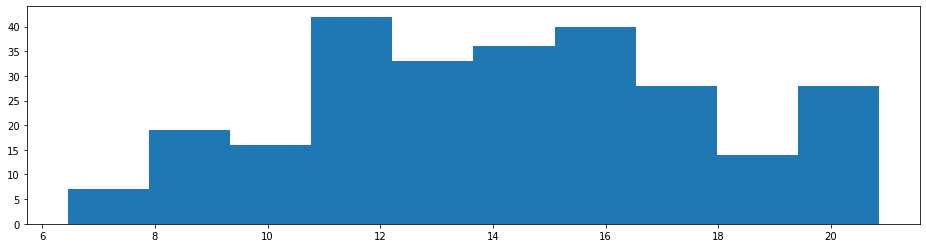

Total customers = 263


In [9]:
# Create a timeline
timeline = Timeline(menu=cake_menu)
timeline.enqueue(GenerateCustomer(0.0)) 

# Simulate for 24 hours
events = timeline.simulate(24.0 * 60.0 * 60.0)

plt.figure(figsize=(16,4))
plt.hist(numpy.array(events['arrive']) / (60*60)) 
plt.show()

print('Total customers = {}'.format(len(events['arrive'])))

## Cashier
The Cashiers job is to stand there, watch the queue of customers and serve each in turn.

This introduces the idea of a callback - it passes one of it's methods into the `watch_queue()` method. This is then stored (it is just a variable, like any other), and then ultimately called as function when there is a customer to serve. Note this subtlety - it is not `Cashier.handle_customer` that is passed, but the `handle_customer()` method that belongs to this particular object, so when it's called it runs on this object. The technical term for this is a _closure_.

In [10]:
class Cashier:
    def __init__(self, timeline):
        timeline.watch_queue('tills', self.handle_customer)
    
    
    def handle_customer(self, timeline, customer):
        task = ServeCustomer(timeline, self, customer)
        timeline.enqueue(task)
    
    
    def after_customer(self, timeline):
        timeline.watch_queue('tills', self.handle_customer)


## Just a Cake Shop
This is the end of the provided code - a shop with one cashier and a menu containing only cake. Customers queue up and select cake, queue, buy cake, and then leave. It's a good life, but that doesn't mean it can't be improved.

The below simulation prints a scatter plot of waiting time for each customer during the day. You should be able to perceive more delays around lunchtime when lots of customers arrive at the same time, for instance.

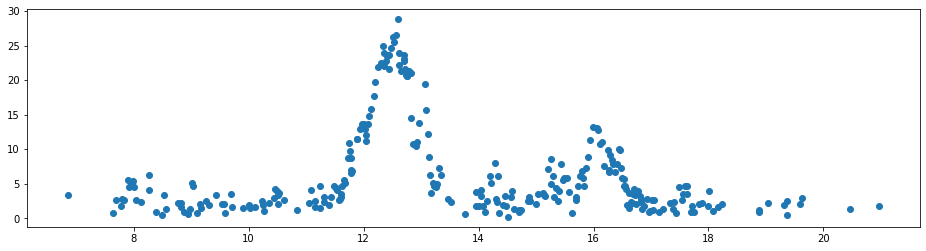

In [11]:
timeline = Timeline(menu=cake_menu)
timeline.enqueue(GenerateCustomer(0.0))

Cashier(timeline)
events = timeline.simulate(24.0 * 60.0 * 60.0)

data = numpy.array(events['leave'])
data[:,0] /= 60 * 60
data[:,1] /= 60

plt.figure(figsize=(16,4))
plt.scatter(data[:,0], data[:,1])
plt.show()

## 1. Two Cashiers

Run a simulation with one cashier and then two cashiers, and plot a histogram of average waiting times for both (in minutes). Bin count of the histogram is up to you!

Hints:
 * You may want to investigate the `plt.axis()` method to make the two histograms have consistant scales.
 * Remember that you will get a different set of customers with each run, so some differences will be down to random chance.

__(2 mark)__

Total customers = 228
Total customers = 244


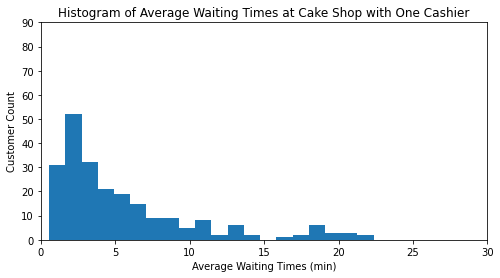

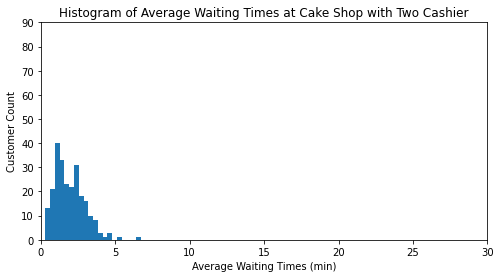

In [12]:
# 1 cashier
timeline = Timeline(menu=cake_menu)
timeline.enqueue(GenerateCustomer(0.0))
Cashier(timeline)
events = timeline.simulate(24.0 * 60.0 * 60.0)
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 
data[:,1] /= 60 
plt.figure(figsize=(8,4))
plt.hist(data[:,1],bins=20) 
print('Total customers = {}'.format(len(events['leave'])))
plt.axis([0, 30, 0, 90])
plt.xlabel('Average Waiting Times (min)')
plt.ylabel('Customer Count')
plt.title('Histogram of Average Waiting Times at Cake Shop with One Cashier')

# 2 cashiers
Cashier(timeline)
Cashier(timeline)
events2 = timeline.simulate(24.0 * 60.0 * 60.0)
data2 = numpy.array(events2['leave'])
data2[:,0] /= 60 * 60 
data2[:,1] /= 60
plt.figure(figsize=(8,4))
plt.hist(data2[:,1],bins=20) 
print('Total customers = {}'.format(len(events2['leave'])))
plt.axis([0, 30, 0, 90])
plt.xlabel('Average Waiting Times (min)')
plt.ylabel('Customer Count')
plt.title('Histogram of Average Waiting Times at Cake Shop with Two Cashier')
plt.show() # eliminate output array

## 2. Purchase Statistics

Modify the ServeCustomer(Task) (above) to record each item purchased and when, then run a 24 hours simulation below and print out how many of every item in the menu was sold, and the takings of the cake shop. You should use the `record` method of the `Timeline` object, with the name of the event for each purchase matching the name from the menu.

__(4 marks)__
 * 2 for modification of ServeCustomer(Task).
 * 2 for extracting statistics and takings from a simulation.

In [13]:
timeline = Timeline(menu=cake_menu)
timeline.enqueue(GenerateCustomer(0.0))
Cashier(timeline)
events = timeline.simulate(24.0 * 60.0 * 60.0) # simulate returns a dict
pc=numpy.array(events['purchased'])

pc.reshape((len(pc)*2,1))
num_BP = str(pc.tolist()).count('Banoffee Pie')
num_BC = str(pc.tolist()).count('Butterfly Cake')
num_CC = str(pc.tolist()).count('Caterpillar Cake')
num_LC = str(pc.tolist()).count('Lava Cake')
num_TM = str(pc.tolist()).count('Tiramisu')
num=[num_BP,num_BC,num_CC,num_LC,num_TM]
print(f'number of Banoffee Pie sold: {num_BP}\nnumber of Butterfly Cake sold: {num_BC}\nnumber of Caterpillar Cake sold: {num_CC}\nnumber of Lava Cake sold: {num_LC}\nnumber of Tiramisu sold: {num_TM}')
print()
cost=[3.80,1.00,20.00,4.20,3.50]
takings=numpy.dot(num,cost)
print(f'takings of the cake shop is: {takings}')

number of Banoffee Pie sold: 93
number of Butterfly Cake sold: 71
number of Caterpillar Cake sold: 55
number of Lava Cake sold: 62
number of Tiramisu sold: 78

takings of the cake shop is: 2057.8


## 3. Coffee Shop
It is madness to not sell coffee. Your task is to modify the system so that the shop serves coffee. This requires that you complete the following tasks:
 * Modify the ServeCustomer(Task) (above) to respond to 'barista' menu item requests by adding them to a `brew` queue in the Timeline object as tuples of `(customer, menu item)`.
 * Adding a `Brew(Task)` class (please ignore the fact that a coffee machine does not use brewing to make coffee!).
 * Adding a `Barista` class as a staff member that watches the `brew` queue and makes each coffee as the requests arrive.
 * Run a simulation to verify it is working, with one `Barista` and two `Cashier`s.
 * Print out a scatter plot of how long it takes to serve the customers ($x$ axis should be time of day, $y$ axis how long it took to be served). Also print out how many people enter the shop (event `'arrive'`) and how many leave (event `'leave'`) to verify that all customers are served.
 
Notes:
 * Brewing does not depend on the customer!
 * Pay attention to the calling pattern of the callback given to `timeline.watch_queue()`

__(15 marks)__

In [14]:
class Brew(Task):
    
    def __init__(self, timeline, barista, customer_coffee):
        self.customer = customer_coffee[0]
        self.coffee = customer_coffee[1]
        self.barista = barista
        '''
        if numpy.random.rand() < 0.2:
            self.delay = 2.0 # They are a regular and already know.
        
        else:
            self.delay = len(timeline.menu) + numpy.random.exponential(30.0)
        '''
        targ=timeline.menu[self.coffee]
        self.delay = numpy.random.uniform(targ[2][0],targ[2][1])

    def time(self):
        return self.delay


    def depends(self):
        yield self.barista


    def __call__(self, timeline):
        self.barista.after_customer(timeline)
        self.customer.receive_item(timeline, self.coffee)
        timeline.record(self.coffee)

In [15]:
class Barista: 
    def __init__(self, timeline):
        timeline.watch_queue('brew',self.handle_customer)
    
    
    def handle_customer(self, timeline, customer): # same mtd as defined in other classes, so 3 inputs, 1 positional
        task = Brew(timeline, self, customer) 
        timeline.enqueue(task)
    
    
    def after_customer(self, timeline):
        timeline.watch_queue('brew', self.handle_customer)

class ServeCustomer(Task):
    def __init__(self, timeline, cashier, customer):
        self.cashier = cashier
        self.customer = customer
        self.Barista=Barista
        
        req = customer.to_buy()
        self.delay = len(req) * 3.0
        
        self.delay += numpy.random.uniform(1.0, 40.0)
        
        self.grabbing = []
        self.brewwing=[]
        for r in req:
            targ = timeline.menu[r]
            if targ[1]=='grab':
                self.delay += numpy.random.uniform(targ[2][0], targ[2][1])
                self.grabbing.append(r)
            elif targ[1]=='barista':
                timeline.join_queue('brew',(self.customer, r))
                self.brewwing.append(r)
                timeline.record('brew',r)
    
    
    def time(self):
        return self.delay


    def depends(self):
        yield self.cashier
        yield self.customer


    def __call__(self, timeline):
        self.cashier.after_customer(timeline)
        for name in self.grabbing:
            self.customer.receive_item(timeline, name)
            timeline.record(name)


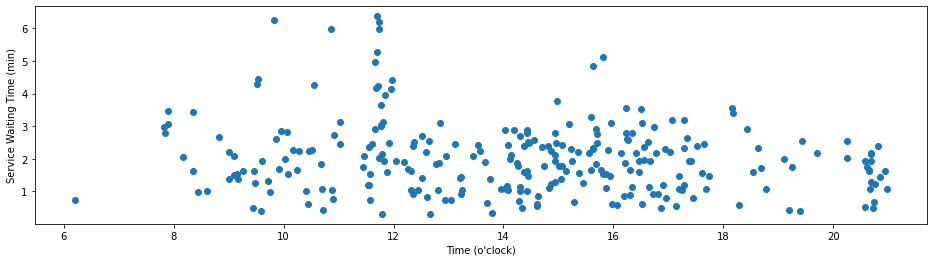

customer arrived: 269
customer left: 269


In [16]:
full_menu = cake_menu.copy()
full_menu['Espresso'] = (2.00, 'barista', (10.0, 20.0))
full_menu['Flat White'] = (2.80, 'barista', (40.0, 90.0))
full_menu['Americano'] = (2.40, 'barista', (20.0, 30.0))
full_menu['Latte'] = (3.20, 'barista', (60.0, 120.0))

timeline = Timeline(menu=full_menu)
timeline.enqueue(GenerateCustomer(0.0))
Cashier(timeline)
Cashier(timeline)
Barista(timeline)
events = timeline.simulate(24.0 * 60.0 * 60.0)
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 
data[:,1] /= 60 

plt.figure(figsize=(16,4))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('Time (o\'clock)')
plt.ylabel('Service Waiting Time (min)')                          
plt.show()


customer_arrive=len(events['arrive'])
customer_leave=len(events['leave'])
print('customer arrived:',customer_arrive)
print('customer left:',customer_leave)

## 4. Everyone wants Coffee

The current purchasing pattern of a customer expressed in `ChoosePurchase(Task)` is not very realistic. You task is to modify it to obey the following rules:
 * Everyone who enters a coffee shop has a 70% chance of buying for themselves, a 30% chance of buying for a group of 2-4 people (including the customer). All group sizes (2, 3 or 4) have equal probability within their 30% bracket.
 * Coffee is always bought for every person (all members of the group).
 * There is a 50:50 chance of cake being bought; if it is then everyone in the group gets one piece of cake.
 * Which particular coffee/cake is selected independently for each person within a group.
 * The probability of each coffee is proporitional to it's price - customers prefer expensive coffee.
 * The probability of cake is inversly proportional to it's price - customers prefer cheap cake.

Rerun the simulation and output:
 * A scatter plot of the time of day vs waiting time.
 * The sales quantities and takings.

Hints:
 * Make sure you're recording the sale of coffee, otherwise the takings will be wrong!
 * You may want to look at the help for [`numpy.random.choice`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.choice.html), paying particulat attention to the `p` keyword argument.

__(5 marks)__
 * 4 marks for the modification of `ChoosePurchase(Task)`
 * 1 mark for graph and generating sales quantities and takings.

In [17]:
class ChoosePurchase(Task):
    def __init__(self, timeline, customer):
        self.customer = customer
        
        if numpy.random.rand() < 0.2:
            self.delay = 2.0 
        
        else:
            self.delay = len(timeline.menu) + numpy.random.exponential(30.0)


    def time(self):
        return self.delay


    def depends(self):
        yield self.customer


    def __call__(self, timeline):
        # cake list
        cake_list=numpy.array(list(cake_menu.values())),numpy.array(list(cake_menu.keys()))
        cake_list=numpy.array([numpy.array(cake_list[0][:,0]),numpy.array(cake_list[1][:])]).transpose()
        cake_list=cake_list[numpy.argsort(cake_list[:,0]),:]     # price low to high
        
        # coffee list
        full_list=numpy.array(list(full_menu.values())),numpy.array(list(full_menu.keys()))
        full_list=numpy.array([numpy.array(full_list[0][:,0]),numpy.array(full_list[1][:])]).transpose()
        full_list=full_list[numpy.argsort(full_list[:,0]),:]
        coffee_list=[]
        for x in full_list:
            if x not in cake_list:
                coffee_list.append(x)
        coffee_list.reverse()
        coffee_list=numpy.array(coffee_list)                    # price high to low
        
        group_size=numpy.random.choice([1,2,3,4],size=1,p=[0.7,0.1,0.1,0.1])
        X=numpy.random.choice([1,0],size=1,p=[0.5,0.5])
        if X==1:
            cake_options=list(cake_list[:,1])
            cake_prob0=list(numpy.divide(list(cake_list[:,0]),sum(list(cake_list[:,0]))))
            scale=1/sum([1/_ for _ in cake_prob0])
            cake_prob=[scale/_ for _ in cake_prob0]                                             # x/price
            cake_buy=numpy.random.choice(cake_options,size=group_size,p=cake_prob)
        
        coffee_options=list(coffee_list[:,1])
        coffee_prob=list(numpy.divide(list(coffee_list[:,0]),sum(list(coffee_list[:,0]))))
        coffee_buy=numpy.random.choice(coffee_options,size=group_size,p=coffee_prob)
        if X==1:
            self.customer.go_buy(timeline, list(cake_buy)+list(coffee_buy))
        else:
            self.customer.go_buy(timeline, list(coffee_buy))

<ipython-input-17-d8f7700cc705>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cake_list=numpy.array(list(cake_menu.values())),numpy.array(list(cake_menu.keys()))
<ipython-input-17-d8f7700cc705>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  full_list=numpy.array(list(full_menu.values())),numpy.array(list(full_menu.keys()))


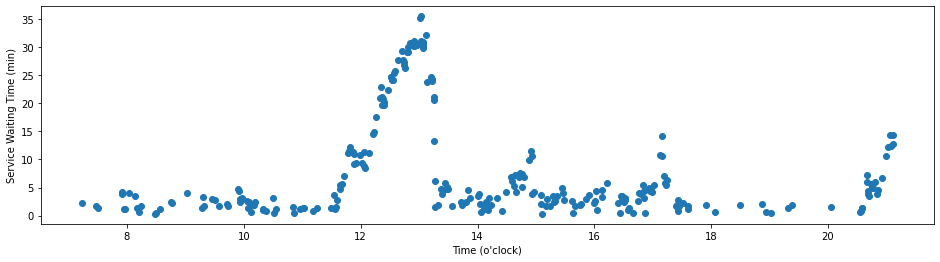

In [18]:
timeline = Timeline(menu=full_menu)
timeline.enqueue(GenerateCustomer(0.0))
Cashier(timeline)
Cashier(timeline)
Barista(timeline)
events = timeline.simulate(24.0 * 60.0 * 60.0)
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60
data[:,1] /= 60 
plt.figure(figsize=(16,4))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('Time (o\'clock)')
plt.ylabel('Service Waiting Time (min)')                           
plt.show()

In [19]:
for r in events.keys():
    if r in full_menu.keys():
        num=len(events[r])
        print(f'number of {r} sold: {num}')

takings=0
for r in events:
    if r in full_menu:
        num=len(events[r])
        takings+=num*full_menu[r][0]
print(f'takings of the cake shop is: {takings}')

number of Espresso sold: 99
number of Lava Cake sold: 23
number of Flat White sold: 111
number of Butterfly Cake sold: 114
number of Latte sold: 118
number of Americano sold: 89
number of Banoffee Pie sold: 23
number of Tiramisu sold: 30
number of Caterpillar Cake sold: 5
takings of the cake shop is: 1603.0
